In [20]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import random
from sklearn.metrics.pairwise import cosine_similarity
import math
from tqdm import tqdm
from dateutil import tz
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
import psycopg2 as pg2
import psycopg2.extras as pgex
this_host='34.211.59.66'
this_user='postgres'
this_password='postgres'
conn = pg2.connect(host = this_host, 
                        user = this_user,
                        password = this_password)

sql_select = '''select created_at, location, tweet_content, cleaned_tweet, hashtags, date, time, date_time  
                from tweets limit 10;'''


cur = conn.cursor(cursor_factory=pgex.RealDictCursor)
cur.execute(sql_select)
rows = cur.fetchall()
conn.close()
df = pd.DataFrame(rows)
df.reset_index(inplace = True)




In [46]:
df

,index,cleaned_tweet,created_at,date,date_time,hashtags,location,time,tweet_content
0,0,what you talking bout lmaooo them was tha days...,Mon Jun 05 18:45:55 +0000 2017,2017-06-05,2017-06-05 18:45:55,None,"bellflower, ca",18:45:55,what you talking bout lmaooo them was tha day...
1,1,"lmao, i wish i thought like this cause shit be...",Mon Jun 05 18:45:55 +0000 2017,2017-06-05,2017-06-05 18:45:55,None,"los angeles, ca",18:45:55,"lmao, i wish i thought like this cause shit be..."
2,2,"wit my natives, at the palace you feel me. lem...",Mon Jun 05 04:32:56 +0000 2017,2017-06-05,2017-06-05 04:32:56,None,"california, usa",04:32:56,"wit my natives, at the palace you feel me. lem..."
3,3,i go to sleep in 2 socks and wake up with one,Mon Jun 05 04:33:07 +0000 2017,2017-06-05,2017-06-05 04:33:07,None,"monterey park, ca",04:33:07,i go to sleep in 2 socks and wake up with one
4,4,my talents include not crying at the movies ev...,Mon Jun 05 04:33:03 +0000 2017,2017-06-05,2017-06-05 04:33:03,None,"tustin, ca",04:33:03,my talents include not crying at the movies ev...
5,5,we took the most unexpected trip to la today. ...,Mon Jun 05 04:36:01 +0000 2017,2017-06-05,2017-06-05 04:36:01,None,"california, usa",04:36:01,we took the most unexpected trip to la today. ...
6,6,i am. it getting a response back from that em...,Mon Jun 05 04:33:05 +0000 2017,2017-06-05,2017-06-05 04:33:05,None,"los angeles, ca",04:33:05,@musicallyhelp i am. it getting a response bac...
7,7,lovvvve snuggles w my baby bear,Mon Jun 05 04:47:36 +0000 2017,2017-06-05,2017-06-05 04:47:36,None,"california, usa",04:47:36,lovvvve snuggles w my baby bear💓🐻
8,8,im actually gonna put in a dj order soon from...,Mon Jun 05 04:35:41 +0000 2017,2017-06-05,2017-06-05 04:35:41,None,"los angeles, ca",04:35:41,@transnoctls im actually gonna put in a dj ord...
9,9,jesus we believe in your name and we ask for ...,Mon Jun 05 04:16:57 +0000 2017,2017-06-05,2017-06-05 04:16:57,None,"california, usa",04:16:57,@ronlybrand jesus we believe in your name and ...


In [23]:
df['created_datetime'] = pd.to_datetime(df['created_at'])
df['year'] = df.created_datetime.apply(lambda x: x.year)
df['month'] = df.created_datetime.apply(lambda x: x.month)
df['day'] = df.created_datetime.apply(lambda x: x.day)
#df['dayofweek'] = df.created_datetime.apply(lambda x: x.dayofweek)
df['hour'] = df.created_datetime.apply(lambda x: x.hour)

In [28]:
df['date'] = df.created_datetime.apply(lambda x: x.date())
df['time'] = df.created_datetime.apply(lambda x: x.time())

In [ ]:
df.created_datetime.d

In [4]:
import pickle
!pip install redis
import redis
redis_ip = '34.211.59.66'
r = redis.StrictRedis(redis_ip)
r.keys()

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


[b'hashtags_tfidf_fit_transform',
 b'hashtag_mean_arr_window18',
 b'hashtag_mean_arr_window2',
 b'hashtags_countvec_fit_transform',
 b'hashtag_mean_arr_window23',
 b'hashtag_mean_arr_window8',
 b'hashtag_mean_arr_window6',
 b'hashtag_mean_arr_window13',
 b'hashtag_mean_arr_window19',
 b'hashtag_mean_arr_window3',
 b'hashtag_mean_arr_window22',
 b'hashtag_mean_arr_window20',
 b'hashtag_mean_arr_window15',
 b'hashtag_mean_arr_window4',
 b'hashtag_mean_arr_window21',
 b'hashtags_countvec_fit',
 b'hashtag_mean_arr_window14',
 b'hashtag_mean_arr_window1',
 b'hashtag_mean_arr_window9',
 b'hashtag_mean_arr_window17',
 b'hashtag_mean_arr_window16',
 b'tweet_tfidf_fit',
 b'tweet_tfidf_fit_transform',
 b'tweet_SVD_fit',
 b'hashtag_mean_arr_window11',
 b'hashtag_mean_arr_window12',
 b'hashtag_mean_arr_window0',
 b'hashtag_mean_arr_window10',
 b'hashtag_mean_arr_window5',
 b'hashtag_mean_arr_window7']

In [5]:
len(df)

155757

In [6]:
hastages_series = df['hashtags']

In [7]:
count_vectorizer = CountVectorizer(min_df = 1, stop_words='english')
hashtags_countvec_fit = count_vectorizer.fit(hastages_series)
hashtags_countvec = pickle.dumps(hashtags_countvec_fit)
r.set('hashtags_countvec_fit', hashtags_countvec)

True

In [8]:
hashtags_countvec = pickle.loads(r.get('hashtags_countvec_fit'))

In [9]:
hashtag_name = hashtags_countvec.get_feature_names()
hashtag_name[5000]

'beige'

In [10]:
time_delta = max(df['created_datetime']) - min(df['created_datetime'])
time_window = time_delta.components.days*24 + time_delta.components.hours
time_lag = timedelta(hours = 6)
time_gap = timedelta(hours = 2)
windows = int(round(time_delta/time_gap,0))
print('start time: ', min(df['created_datetime']),'\n',\
      'end time:  ', max(df['created_datetime']),'\n',\
      'total hours: ',time_window,'\n',\
      'time lag: ', time_lag,'\n',\
      'time gap: ', time_gap,'\n',\
      'time windows: ', windows)

start time:  2017-05-31 23:50:46 
 end time:   2017-06-09 00:01:11 
 total hours:  192 
 time lag:  6:00:00 
 time gap:  2:00:00 
 time windows:  96


In [1]:
time_delta = max(df['created_datetime']) - min(df['created_datetime'])
time_window = time_delta.components.days*24 + time_delta.components.hours
time_lag = timedelta(hours = 2)
time_gap = timedelta(hours = 1)
windows = int(round(time_delta/time_gap,0))
time_format = '%Y-%h-%d %a %I %p'
from_zone = tz.tzutc()
#to_zone = tz.tzlocal()
to_zone = 'US/Pacific'
def hashtag_trend(hashtag):
    hashtag = hashtag.lower()
    arr = []
    start_time = min(df['created_datetime'])
    for window in range(windows):
        start_time = start_time
        end_time = start_time + time_lag
        subset = df['hashtags'][((df['created_datetime'] < end_time) & (df['created_datetime'] > start_time))]
        h = subset.str.contains(hashtag).mean()
        arr.append(h)
        start_time += time_gap
    arr = np.array(arr)  
    
    grad = np.gradient(arr)
    tr = np.argwhere(grad>.01).reshape(1,-1)[0]
    spikes = []
    [spikes.append(i) for i in tr if (i-1) not in tr]
    plt.figure(figsize=(14,7))
    plt.plot(arr, label='hashtag frequency')
    plt.plot(grad, label='frequency slope')
    
    for i,j in enumerate(spikes):
        spiketime = (min(df['created_datetime']) + time_gap * j) 
        spiketime = spiketime.replace(tzinfo=from_zone)
        spiketime_et = spiketime.astimezone(to_zone)
        spiketime_et = spiketime_et.strftime(time_format)
        
        plt.axvline(j, color = 'r',linestyle='dashed', label = 'trending start: {}'.format(spiketime_et))
    plt.legend()    
    return
    

NameError: name 'df' is not defined

In [2]:
hashtag_trend('nbafinals')

NameError: name 'hashtag_trend' is not defined

In [88]:
np.argmax(nbafinals_grad).reshape(1,-1)[0]

array([124])

In [ ]:
nbafinals_grad[61]

In [80]:
nbafinals_grad[23]

0.046130180327304676

In [81]:
(np.argwhere(nbafinals_grad>.01).reshape(1,-1)[0])

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


array([23, 24, 94, 95, 96, 97])

In [82]:
spikes = []
tr = np.argwhere(nbafinals_grad>.01).reshape(1,-1)[0]
[spikes.append(i) for i in tr if (i-1) not in tr]
        
spikes        

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


[23, 94]

In [83]:
np.argmax(nbafinals)

125

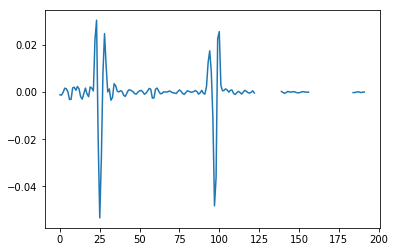

In [84]:
plt.plot(np.gradient(nbafinals_grad))

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


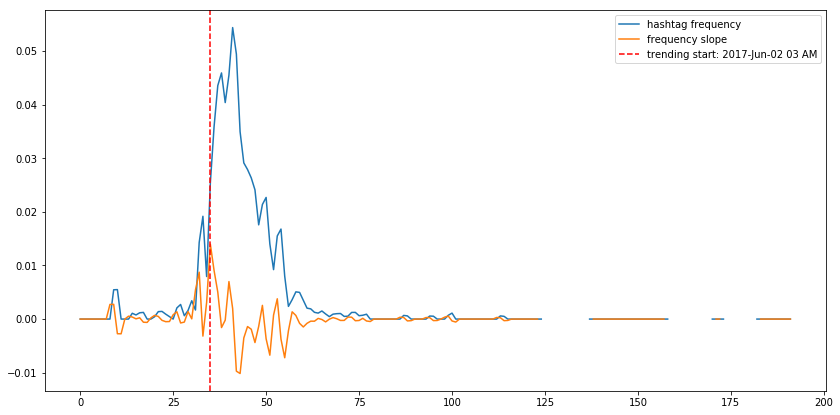

In [96]:
hashtag_trend('nationaldonutday')

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


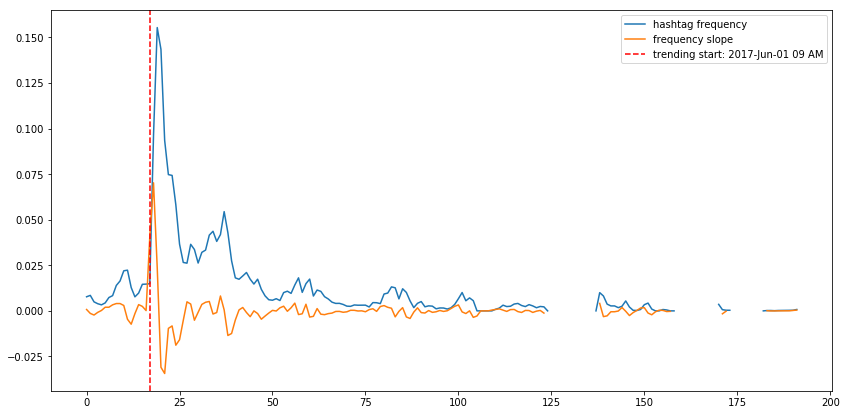

In [97]:
hashtag_trend('paris|climate')

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


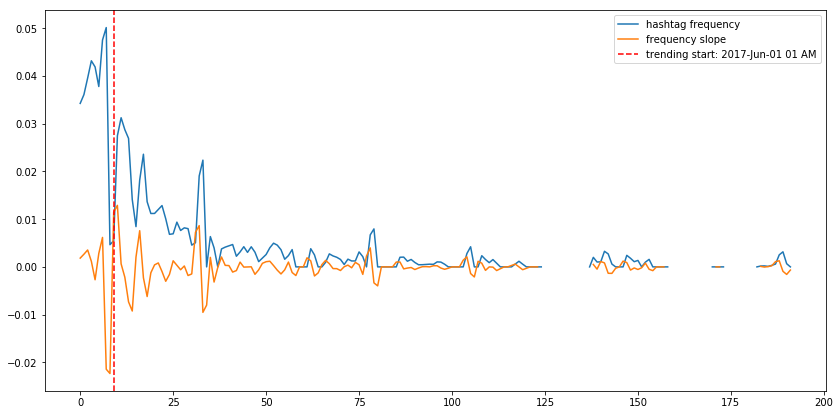

In [98]:
hashtag_trend('covfefe')

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


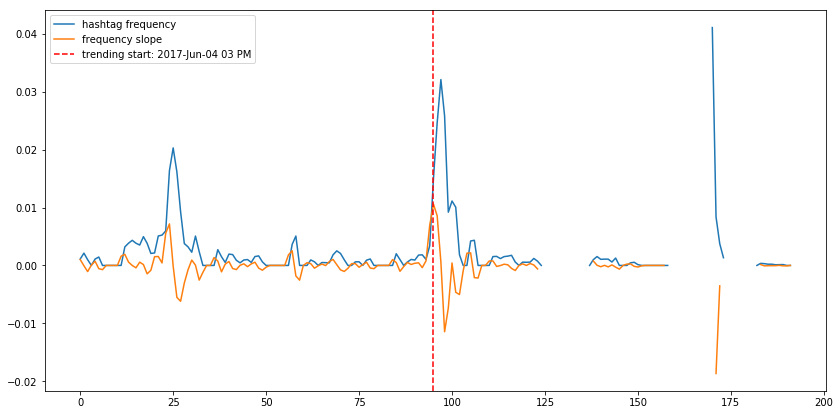

In [99]:
hashtag_trend('Warriors')

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


TypeError: 'NoneType' object is not iterable

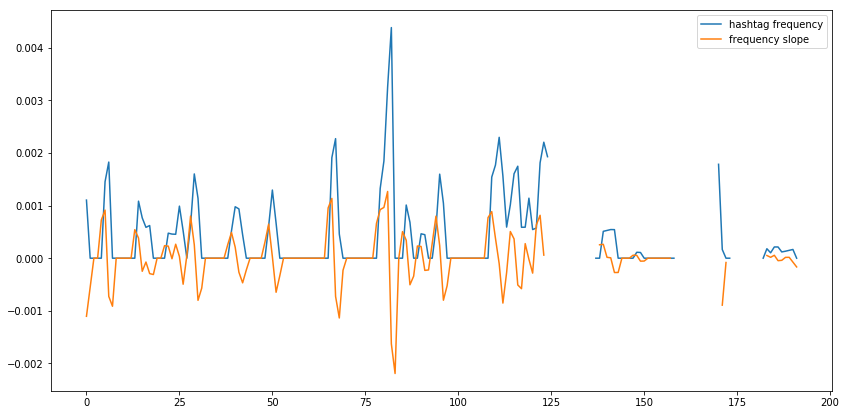

In [100]:
russian, russian_grad = hashtag_trend('Russian')

In [ ]:
trump, trump_grad = hashtag_trend('trump')

In [ ]:
china, china_grad = hashtag_trend('china')